Sampling interval: 1.000 hours/sample
Top 5 dominant periods:
1. Frequency = 0.1429 cycles/day, Amplitude ≈ 4.68e+04, Period ≈ 7.000 days (≈ 168.0 hours)
2. Frequency = 0.0027 cycles/day, Amplitude ≈ 4.27e+04, Period ≈ 365.167 days (≈ 8764.0 hours)
3. Frequency = 0.0005 cycles/day, Amplitude ≈ 4.19e+04, Period ≈ 2191.000 days (≈ 52584.0 hours)
4. Frequency = 0.9995 cycles/day, Amplitude ≈ 3.92e+04, Period ≈ 1.000 days (≈ 24.0 hours)
5. Frequency = 1.0005 cycles/day, Amplitude ≈ 3.29e+04, Period ≈ 1.000 days (≈ 24.0 hours)


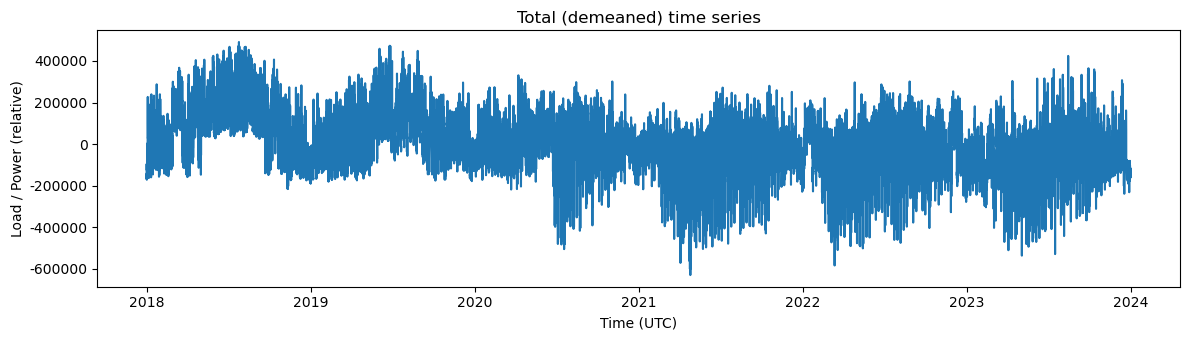

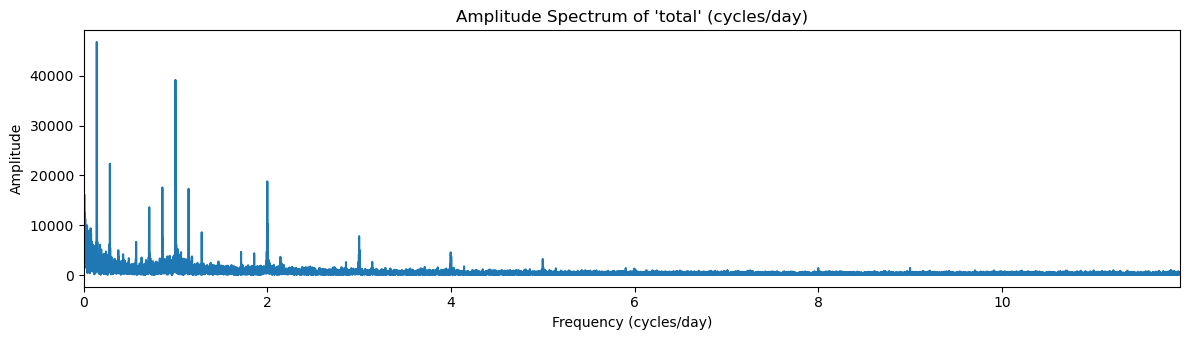

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ==================== SETTINGS ====================
csv_path = Path("electricity_P.csv")   # Input file
top_k = 5                               # Number of dominant frequencies to display
resample_rule = "1H"                    # Expected time interval (1 hour)
# ==================================================

# 1) Read only the columns we care about
df = pd.read_csv(
    csv_path,
    usecols=["datetime_utc", "total"],
    parse_dates=["datetime_utc"]
)

# 2) Set datetime as index and clean numeric values
df = df.set_index("datetime_utc").sort_index()
s = pd.to_numeric(df["total"], errors="coerce")

# 3) Resample hourly and fill missing data if needed
s = s.resample(resample_rule).mean().interpolate("time")

# Sampling interval in hours
dt_hours = (s.index[1] - s.index[0]).total_seconds() / 3600.0
samples_per_day = 24.0 / dt_hours

# 4) Demean and apply Hann window
x = s.values.astype(float)
x = x - np.nanmean(x)
window = np.hanning(len(x))
xw = x * window

# 5) Real FFT
X = np.fft.rfft(xw)
window_correction = np.sum(window) / len(window)
X = X / (len(x) * window_correction)

# 6) Frequency axis (cycles per day)
freq_cph = np.fft.rfftfreq(len(x), d=dt_hours)
freq_cpd = freq_cph * 24.0

# 7) Amplitude spectrum (single-sided)
amplitude = np.abs(X)
if len(amplitude) > 1:
    amplitude[1:-1] *= 2.0

# 8) Find dominant frequencies (exclude DC)
mask = freq_cpd > 0
freq_pos = freq_cpd[mask]
amp_pos = amplitude[mask]

idx = np.argsort(amp_pos)[::-1][:top_k]
dominant_freqs = freq_pos[idx]
dominant_amps = amp_pos[idx]
dominant_period_days = 1.0 / dominant_freqs
dominant_period_hours = dominant_period_days * 24.0

# 9) Print dominant frequencies (decimal format)
print(f"Sampling interval: {dt_hours:.3f} hours/sample")
print(f"Top {top_k} dominant periods:")
for i, (f, a, pdays, phours) in enumerate(zip(dominant_freqs, dominant_amps, dominant_period_days, dominant_period_hours), 1):
    print(f"{i}. Frequency = {f:.4f} cycles/day, "
          f"Amplitude = {a:,.2f}, "
          f"Period = {pdays:.3f} days ({phours:,.1f} hours)")

# 10) Matplotlib font setup (avoid glyph warnings)
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

# 11) Plot time series (demeaned)
plt.figure(figsize=(12, 3.5))
plt.plot(s.index, x)
plt.title("Total (demeaned) time series")
plt.xlabel("Time (UTC)")
plt.ylabel("Load / Power (relative)")
plt.tight_layout()
plt.show()

# 12) Plot amplitude spectrum
plt.figure(figsize=(12, 3.5))
plt.plot(freq_cpd, amplitude)
plt.xlim(0, np.percentile(freq_cpd, 99.5))
plt.title("Amplitude Spectrum of 'total' (cycles/day)")
plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()
